In [2]:
import torch
import argparse
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle
import time
from scipy.optimize import minimize
from tqdm import *
plt.rcParams.update({'font.size': 20})
from DBNN import DBNN, TimeSeriesDataset, Bilinear

In [2]:
model = Bilinear(10, 10)

In [3]:
model.weight

Parameter containing:
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4210e-02,  4.7775e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.7478e-01, -1.9216e-01, -7.2734e-02,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.9029e-01,  6.0887e-02,  1.7690e-01,  6.4508e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.2662e-01, -1.5749e-01,  1.4458e-01, -4.9834e-02,  1.7136e-02,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.9494e-01,  1.6583e-02,  3.0184e-02,  2.4039e-01,  3.0202e-02,
          -4.2546e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.2839e-01,  6.0350e-02,  1.6940e-02,  2.2451e-01,  1.5604e-0

In [6]:
class BilinearModified(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in1_features, in2_features), **factory_kwargs))

        if bias:
            # Use register_buffer to make bias a non-trainable fixed value (-70)
            # self.register_buffer('bias', torch.tensor([-70.0], **factory_kwargs))
            self.bias = Parameter(torch.tensor([-66.3], **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        # if bias:
        #     self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)
        # if self.bias is not None:
        #     nn.init.uniform_(self.bias, -bound, bound)
        
        # Zero out the diagonal elements of the weight matrix
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        # Ensure diagonal elements are zero during the forward pass as well
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

        return F.bilinear(input1, input2, self.weight, self.bias)

    def extra_repr(self) -> str:
        return (f'in1_features={self.in1_features}, in2_features={self.in2_features}, '
                f'out_features={self.out_features}, bias={self.bias is not None}')


class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    

# input size: (batch_size, N_synapse, time_dur)
# kernels size: (N_synapse, 1, time_dur)
# output after convolution: (batch_size, N_synapse, time_dur)
# transpose to (batch_size, time_dur, N_synapse)
# bilinear matrix size: (N_synapse, N_synapse, 1)
# output size: (batch_size, time_dur)

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 5)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 20)
        self.omega = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1).to(self.device)

    def create_kernels(self):
        T = torch.arange(self.time_dur).to(self.device)
        N = self.num_dimensions
        net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        net_omega = self.omega.unsqueeze(1)  # (N, 1)

        kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
        return kernels.unsqueeze(1)
        
    def forward(self, x):

        kernels = self.create_kernels()
        kernel_flipped = torch.flip(kernels, dims=[2])

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped, groups=self.num_dimensions, padding=self.time_dur - 1)[:, :, :self.time_dur][:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)

In [3]:
data = np.load('/home/mjy/project/bilinear_network/NC_code/data/data_5s_active.npz')

# input_data = data['coarse_ip_m_array']
# output_data = data['coarse_v_array']
input_data = data['ip']
output_data = data['op']

train_input = torch.tensor(input_data[:1000], dtype=torch.float32)
train_output = torch.tensor(output_data[:1000], dtype=torch.float32)

In [23]:
num_dimensions = train_input.size()[1]
time_dur = train_input.size()[2]
# print(f'Number of synapses is: {num_dimensions}')
# print(f'Time duration is: {int(time_dur-1)} ms')

model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device='cpu')

In [24]:
y = model(train_input)

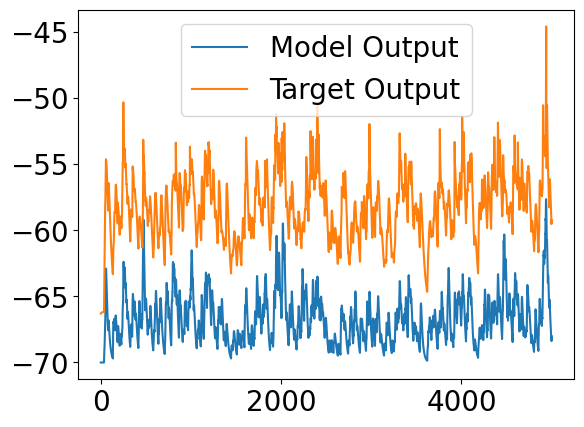

In [25]:
plt.plot(y[0].detach(), label='Model Output')
plt.plot(output_data[0], label='Target Output')
plt.legend()